# Restaurant Sales Forecasting: A Time Series Modeling Approach Using ARIMA and Prophet
***By Samuel Oyedele***

## Table of Contents
- [Introduction](#intro)
- [Data Preparation](#dpa)
- [Exploratory Data Analysis](#eda)
- [ARIMA Model](#arima)
- [Prophet Model](#prophet)
- [Model Refinement](#refine)
- [Forecasting Future Sales](#forecast)
- [Conclusion](#conclude)


<a id ="intro"></a>
## Introduction

> The goal of this project is to analyze daily restaurant sales data and build predictive models capable of forecasting future sales trends. The project aims to compare classical and modern time series forecasting methods — **ARIMA** and **Prophet** — evaluate their performance, and refine the most accurate model for 30-day future sales forecasting.

<a id ="dpa"></a>
## Data Preparation
> Steps for preparing, cleaning, and aggregating sales data.

### Import Libaries and Prepare Data

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# import data - excel file
df = pd.read_excel("restaurant_sales_data.xlsx")

# preview
df.head()

,Order ID,Customer ID,Category,Item,Price,Quantity,Order Total,Order Date,Payment Method
0,ORD_705844,CUST_092,Side Dishes,Side Salad,3.0,1.0,3.0,2023-12-21,Credit Card
1,ORD_338528,CUST_021,Side Dishes,Mashed Potatoes,4.0,3.0,12.0,2023-05-19,Digital Wallet
2,ORD_443849,CUST_029,Main Dishes,Grilled Chicken,15.0,4.0,60.0,2023-09-27,Credit Card
3,ORD_630508,CUST_075,Drinks,NaN,NaN,2.0,5.0,2022-08-09,Credit Card
4,ORD_648269,CUST_031,Main Dishes,Pasta Alfredo,12.0,4.0,48.0,2022-05-15,Cash


In [58]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17534 entries, 0 to 17533
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        17534 non-null  object        
 1   Customer ID     17534 non-null  object        
 2   Category        17534 non-null  object        
 3   Item            15776 non-null  object        
 4   Price           16658 non-null  float64       
 5   Quantity        17104 non-null  float64       
 6   Order Total     17104 non-null  float64       
 7   Order Date      17534 non-null  datetime64[ns]
 8   Payment Method  16452 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1.2+ MB


In [59]:
#Aggregate sales by day (in case there are multiple orders per day)
daily_sales = df.groupby('Order Date')['Order Total'].sum().reset_index()

#preview
daily_sales.head()

,Order Date,Order Total
0,2022-01-01,640.0
1,2022-01-02,479.0
2,2022-01-03,317.0
3,2022-01-04,628.0
4,2022-01-05,447.5


In [60]:
# Set index for time series - order date
daily_sales = daily_sales.set_index('Order Date').sort_index()

daily_sales.head()

,Order Total
Order Date,
2022-01-01,640.0
2022-01-02,479.0
2022-01-03,317.0
2022-01-04,628.0
2022-01-05,447.5


<a id ="eda"></a>
## Exploratory Data Analysis
> Visualize the sales trends and patterns

### Visualize the sales trend

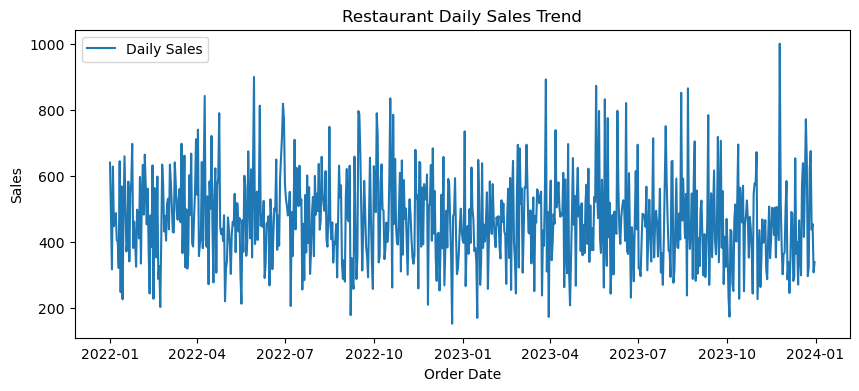

In [86]:
# create figure
plt.figure(figsize=(10,4))

# plot trend
plt.plot(daily_sales.index, daily_sales['Order Total'], label='Daily Sales')
plt.title('Restaurant Daily Sales Trend')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()

plt.show()

### Decompose the series into trend, seasonality and residuals using statsmodels

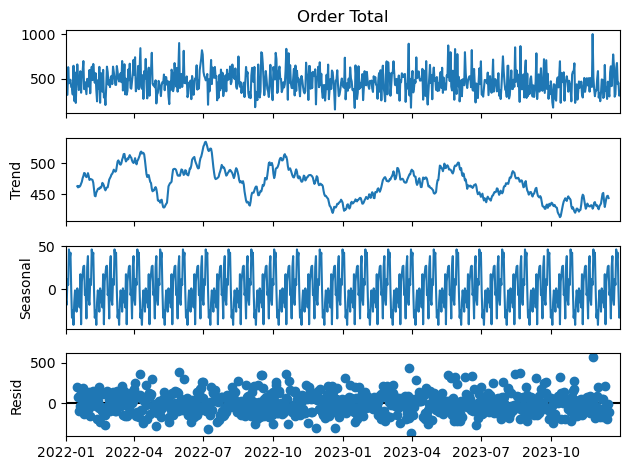

In [85]:
# import statsmodels library for seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose- seasonal_decompose(time series, model='additive', period)
result = seasonal_decompose(daily_sales['Order Total'], period=30)

#plot result
result.plot()

plt.show()

> This help undersatand the series trend, seasonal patterns and spot any unusual data points (anomalies)

### Detect anomalies using STL decomposition residuals

In [63]:
# import statsmodels library for detection
from statsmodels.tsa.seasonal import STL

# STL(data, period)
stl = STL(daily_sales['Order Total'], period=7).fit()  # weekly seasonality
resid = stl.resid # get residuals
threshold = 3 * resid.std()
anoms_stl = daily_sales[abs(resid) > threshold]

print("Anomalies from STL decomposition:")
print(anoms_stl)

Anomalies from STL decomposition:
            Order Total
Order Date             
2022-05-30        899.0
2023-03-28        891.5
2023-06-10        796.5
2023-11-25        999.5


<a id='arima'></a>
## ARIMA Model
> Building and evaluating an ARIMA model

### Forecast sales with ARIMA (Autoregressive Integrated Moving Average)

In [64]:
# import statsmodels library for forcasting time series
from statsmodels.tsa.arima.model import ARIMA

# Train/test split
train = daily_sales['Order Total'][:-30] # all data except the last 30 days

test = daily_sales['Order Total'][-30:] # last 30 days as test (which the model didn’t see)

<p> Using statsmodels.tsa.arima.model.ARIMA(data,order(p,q,r), seasonal_order(P,D,Q,s) </p>

<p> The (p,d,q) order of the model for the autoregressive, differences, and moving average components.d is always an integer, while p and q may either be integers or lists of integers.</p>

- Autoregressive models: AR(p)
- differences(d)
- moving average models: MA(q)

In [65]:
# Fit ARIMA with weekly seasonality
model = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,1,7))

fit = model.fit()

C:\Users\MY PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\MY PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\MY PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
# Forecast 30 days - get_forecast
forecast = fit.get_forecast(steps=30)

pred = forecast.predicted_mean # calculate predicted mean for the 30 days

conf = forecast.conf_int() #confidence intervals

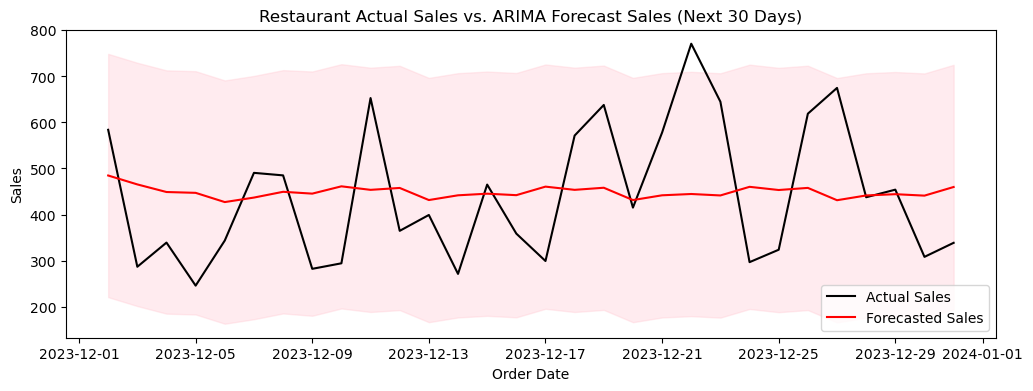

In [90]:
# plot to compare the forecast with the actual sales
plt.figure(figsize=(12,4))

plt.plot(test.index, test, label="Actual Sales", color="black") #actual sales
plt.plot(test.index, pred, label="Forecasted Sales", color="red") # forecast sales
plt.fill_between(pred.index, conf.iloc[:,0], conf.iloc[:,1], color="pink", alpha=0.3)
plt.title("Restaurant Actual Sales vs. ARIMA Forecast Sales (Next 30 Days)")
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()

plt.show()

### Evaluate forecast accuracy

In [68]:
# import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# compare prediction to the actual sales
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 126.69, RMSE: 146.87, MAPE: 31.67%


> MAE = 126.69 - On average, the daily forecasted sales were off by about $126.69.

> MAPE (Mean Absolute Percentage Error) of 31.67% means that, on average,
the daily forecasts were off by about 31.7% of the actual sales value.

> On a typical day, the forecasted sales were either 147 too high or 147 too low compared to the actual sales — about a 30% deviation.

> The model is not good enough for future forecasting. There is a need for improvement.

<a id = "prophet"></a>
## Prophet Model
> Training and evaluating Prophet model for better trend and seasonality capture.

### Using Prophet for Forecasting Sales

In [69]:
# import prophet model
from prophet import Prophet

# Aggregrate by date for the restaurant sales data
r_sales = df.groupby('Order Date')['Order Total'].sum().reset_index()

# Rename columns for Prophet
r_sales.columns = ['ds','y']

r_sales.head()

,ds,y
0,2022-01-01,640.0
1,2022-01-02,479.0
2,2022-01-03,317.0
3,2022-01-04,628.0
4,2022-01-05,447.5


<p> Prophet requires column names: </p>

- ds → datestamp
- y → numeric target variable (sales)


### Fit Prophet Model

In [70]:
# Split dataset (last 30 days for testing)
train_ = r_sales[:-30]
test_ = r_sales[-30:]

ml = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
ml.fit(train_)

# using Prophet.make_future_dataframe.
future = ml.make_future_dataframe(periods=30)
# Predict
fcast = ml.predict(future)

# Extract last 30 days of forecast
prd = fcast[['ds', 'yhat']].tail(30)
                                
#merge with the actual sales
merged = test_.merge(prd, on='ds')

merged.head()

13:30:46 - cmdstanpy - INFO - Chain [1] start processing
13:30:49 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,yhat
0,2023-12-02,584.0,444.983183
1,2023-12-03,286.5,460.058281
2,2023-12-04,339.0,448.812861
3,2023-12-05,245.5,448.520398
4,2023-12-06,343.5,416.926267


> y- actual sales, yhat - forecast sales

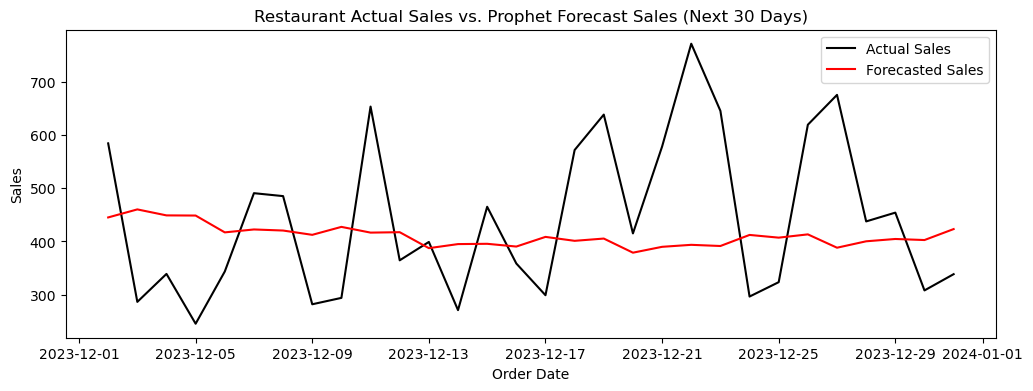

In [87]:
# plot
plt.figure(figsize=(12,4))

plt.plot(merged['ds'],merged['y'], label='Actual Sales', color='Black')
plt.plot(merged['ds'],merged['yhat'], label='Forecasted Sales', color='Red')
plt.title("Restaurant Actual Sales vs. Prophet Forecast Sales (Next 30 Days)")
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()

plt.show()

### Model Evaluation

In [72]:
# Calculate metrics
mae_p = mean_absolute_error(merged['y'], merged['yhat'])
rmse_p = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mape_p = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print(f"MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%")

MAE: 131.57, RMSE: 156.56, MAPE: 30.36%


> The Prophet model’s **MAPE = 30.36%**, which means on average the forecasted sales differ from the actual sales by **~30.36%.**. That means the daily forecast is roughly $157 above or below the true value.

<a id ="refine"></a>
## Model Refinement
> Removing outliers and tuning Prophet hyperparameters.

### Improving the Prophet's accuracy

#### Remove outliers (extreme spikes or dips) and adjust changepoint sensitivity

Prophet can get misled by extreme outliers. Try removing or smoothing them first:

In [73]:
# Handle Outliers
Q1 = r_sales['y'].quantile(0.25)
Q3 = r_sales['y'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

# filter out the outliers
cleaned_sales = r_sales[(r_sales['y'] >= lower) & (r_sales['y'] <= upper)]

# Re-trained - split dataset (last 30 days for testing)
train_new = cleaned_sales[:-30]
test_new = cleaned_sales[-30:]

# Tunr Prophet hyperparameters
cleaned_model = Prophet(  
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.5,   # more responsive to trend changes
    seasonality_prior_scale=15,    # allows more flexible seasonality
)

# Fit model and forecast
cleaned_model.fit(train_new)
future_c = cleaned_model.make_future_dataframe(periods=30)
forecast_c = cleaned_model.predict(future_c)

# Extract last 30 days of forecast
pred_c = forecast_c[['ds', 'yhat']].tail(30)
merg_c = test_.merge(pred_c, on='ds')

# Calculate metrics
mae_c = mean_absolute_error(merg_c['y'], merg_c['yhat'])
rmse_c = np.sqrt(mean_squared_error(merg_c['y'], merg_c['yhat']))
mape_c = np.mean(np.abs((merg_c['y'] - merg_c['yhat']) / merg_c['y'])) * 100

print(f"MAE: {mae_c:.2f}, RMSE: {rmse_c:.2f}, MAPE: {mape_c:.2f}%")

13:32:32 - cmdstanpy - INFO - Chain [1] start processing
13:32:33 - cmdstanpy - INFO - Chain [1] done processing


MAE: 131.96, RMSE: 163.94, MAPE: 28.33%


> The **MAPE** has been reduced to **28.33%** which is well acceptable for restaurant forecasting.

<a id = "forecast"></a>
## Forecasting Future Sales
> Forecasting 30 days of future sales and visualizing predictions.

### Using the refined Prophet model to predict future (unknown) sales trends

> Forecasting the restuarant sales for next 30 days from the last actual sales.

13:33:29 - cmdstanpy - INFO - Chain [1] start processing
13:33:31 - cmdstanpy - INFO - Chain [1] done processing


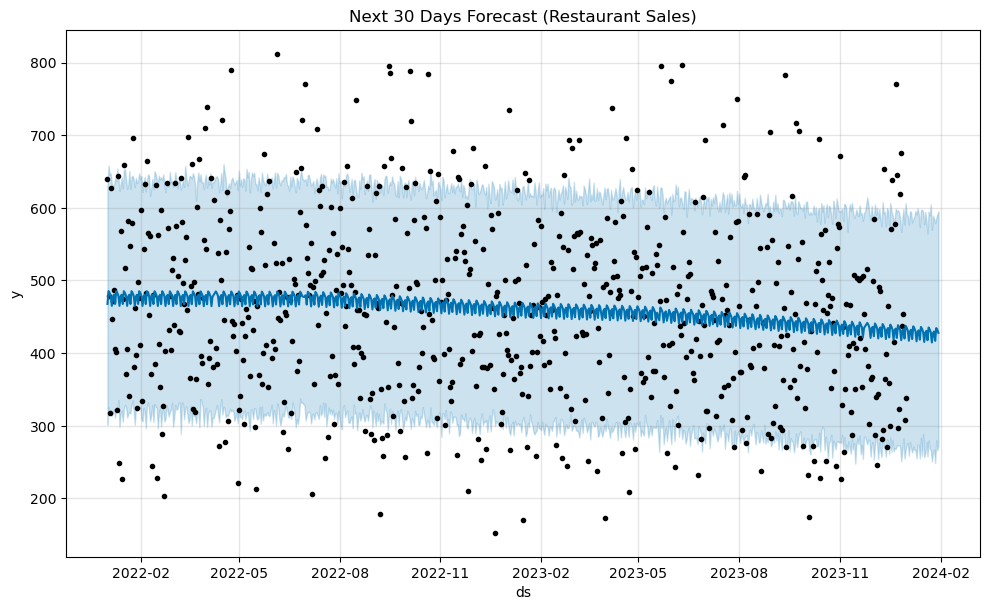

In [74]:
final_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=15
)

final_model.fit(cleaned_sales)

future_p = final_model.make_future_dataframe(periods=30)
future_forecast = final_model.predict(future_p)

final_model.plot(future_forecast)
plt.title("Next 30 Days Forecast (Restaurant Sales)")
plt.show()


### Forecast Visualization

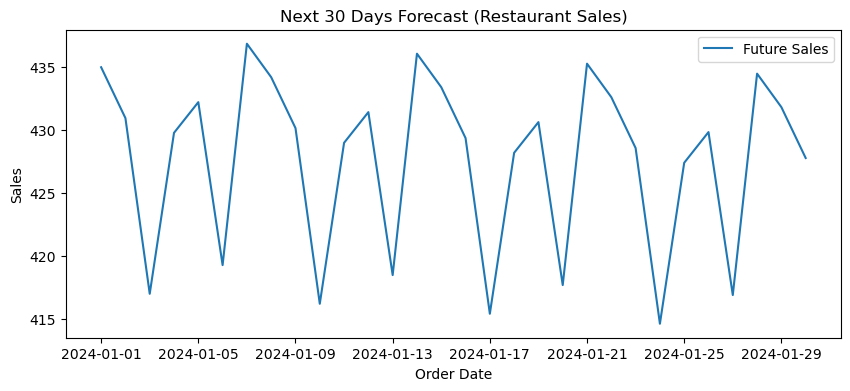

In [89]:
future_pred = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

plt.figure(figsize=(10,4))
plt.plot(future_pred['ds'], future_pred['yhat'], label='Future Sales')
plt.title("Next 30 Days Forecast (Restaurant Sales)")
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

<a id = "conclude"></a>
## Conclusion

- ARIMA was suitable for short, stable patterns but underperformed due to weak seasonal adaptability.
- Prophet, designed for business time series, handled seasonality and irregularities better.
- Removing outliers and tuning Prophet parameters significantly improved accuracy.
- The refined model provides a more reliable forecast for business planning and resource management.